# Plot "recency effect" from simulation of RNN

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from itertools import product
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

## Data

In [34]:
alphabet_size = 2
string_size = 10
n_labels = 3
batch_size = 32

# x: all possible strings
alphabet = [i for i in range(alphabet_size)]
x = [s for s in product(alphabet, repeat=string_size)]
n_strings = len(x)

# y: arbitary labels
y = np.random.randint(0,n_labels,n_strings)

# Tensors
x = torch.tensor(x)
y = torch.tensor(y)

dataset = TensorDataset(x,y)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Model

In [73]:
class RNN(nn.Module):
    def __init__(self, alphabet_size, embedding_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.alphabet_size = alphabet_size
        self.input_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.embedding = nn.Embedding(alphabet_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self,x):
        self.embeds = self.embedding(x)
        self.embeds.retain_grad()
        # embedding:[batch, string_size, embedding_size]
        output, (h_n, c_n) = self.rnn(self.embeds)
        h_n = h_n.squeeze(0)
        # h_n: [batch, hidden_size]
        out = self.out(h_n)
        # [batch, output_size]
        return out

In [80]:
embedding_size = 4
hidden_size = 128
model = RNN(alphabet_size, embedding_size, hidden_size, n_labels)

## Train

In [81]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = Adam(model.parameters(), lr=0.001)

In [82]:
n_epochs = 100
print_every = 100
losses = []
loss_data = []
grad_data = []

In [83]:
# Training loop
for epoch_i in range(n_epochs):
    for batch_i, (x,y) in enumerate(loader):
        optimizer.zero_grad()
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        loss.backward()
        
        # Get norm of gradient w.r.t. embeddings
        grad = model.embeds.grad # [batch, string_size, embedding_size]
        norm = torch.linalg.norm(grad, dim=2) # [batch, string_size]
        norm = torch.mean(norm, dim=0).numpy() # [string_size]
        grad_data.append(norm)
        
        optimizer.step()
        
        losses.append(loss.data.item())
        loss_data.append(loss.data.item())
        
        if batch_i % print_every == 0:
            print("Epoch: {}, Step: {}, Loss: {}".format(epoch_i, batch_i, np.mean(losses)))
            losses = []

Epoch: 0, Step: 0, Loss: 1.1021921634674072
Epoch: 1, Step: 0, Loss: 1.0998642556369305
Epoch: 2, Step: 0, Loss: 1.097956296056509
Epoch: 3, Step: 0, Loss: 1.0998298525810242
Epoch: 4, Step: 0, Loss: 1.0974066182971
Epoch: 5, Step: 0, Loss: 1.0982087589800358
Epoch: 6, Step: 0, Loss: 1.098199650645256
Epoch: 7, Step: 0, Loss: 1.0975697450339794
Epoch: 8, Step: 0, Loss: 1.097626082599163
Epoch: 9, Step: 0, Loss: 1.0969012826681137
Epoch: 10, Step: 0, Loss: 1.097111999988556
Epoch: 11, Step: 0, Loss: 1.097332552075386
Epoch: 12, Step: 0, Loss: 1.0971559025347233
Epoch: 13, Step: 0, Loss: 1.096979919821024
Epoch: 14, Step: 0, Loss: 1.0972072593867779
Epoch: 15, Step: 0, Loss: 1.0972236469388008
Epoch: 16, Step: 0, Loss: 1.0978604592382908
Epoch: 17, Step: 0, Loss: 1.096547145396471
Epoch: 18, Step: 0, Loss: 1.0975089631974697
Epoch: 19, Step: 0, Loss: 1.0967069901525974
Epoch: 20, Step: 0, Loss: 1.0960488803684711
Epoch: 21, Step: 0, Loss: 1.0973587669432163
Epoch: 22, Step: 0, Loss: 1.09

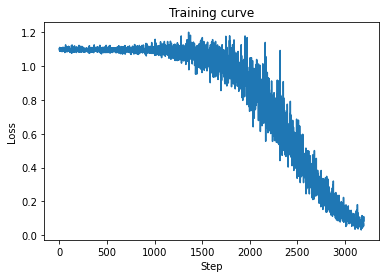

In [84]:
plt.plot(loss_data)
plt.title("Training curve")
plt.ylabel("Loss")
plt.xlabel("Step")
plt.show()

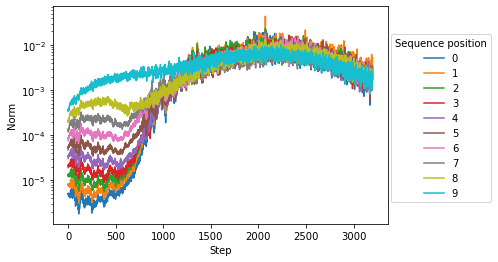

In [120]:
plt.plot(grad_data)
plt.legend(range(string_size), loc=(1.01,0.1), title="Sequence position")
#plt.ylim([0.0, 0.001])
plt.yscale("log")
plt.ylabel("Norm")
plt.xlabel("Step")
plt.savefig("recency_steps.png", bbox_inches="tight", dpi=300)
plt.show()

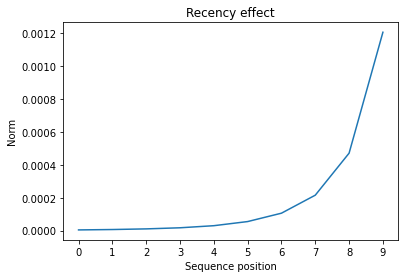

In [121]:
plt.plot(np.mean(grad_data[:500], axis=0))
plt.title("Recency effect")
plt.xticks(range(string_size))
plt.xlabel("Sequence position")
plt.ylabel("Norm")
plt.savefig("recency_seq_position.png", bbox_inches="tight", dpi=300)
plt.show()